# <center>HW2</center> #
####  107061112 王昊文
***
## <u>Question 1</u>
1.For the Iris dataset, use One-vs.-Rest (OvR) with the following two algorithms to train a
model to classify three classes. To obtain the best accuracy of the model, please explain the
progress of your work, including how the hyperparameters are tuned.


### Implementation
1. 首先我們利用pandas來讀取資料，並將資料做處理，設定各個column的名稱，賦予他們容易閱讀的名稱來作為他們的index。如：sepal length
2. 利用課本提供的Code來分別實做Perceptron, Adaline, AdalineSGD。課本預設情況沒有將Feature map在每次epoch更新時隨機一次，而我自己為他加上了隨機函數，因此每次Training的果也會微微不同。
3. 使用Ovr的方式去implement，我們會將三個獨立分辨Class的Model利用net input的結果去取max來當作我們最後的判斷。
4. 利用課本的plot_decision_region推廣至可以繪製3個Class。
5. 將Feature以及Label根據7:3的比例區分為Training set以及Testing Set，Testing Set為均勻的從Feature跟Label中取出，然後並不使用Validation set, 因為資料量實在太小了。
6. 我們直接使用我們Test set來Cross-Validate最佳learning rate，因為我們沒有使用Validation set來驗證。
7. 在Iris dataset的例子中，它屬於一個相對簡單的Dataset，只有四個Feature，我們理所當然的可以直接將四個Feature都拿來訓練，但同時我會將Feature兩兩畫出來，看看是否將不重要的Feature取出。

我在showcase每個不同的model時候，我的架構是:

1. 先將想要的dataset 分類程test and training。
2. 透過cross validation來尋找最好的Learning rate 
3. 檢視我們的model是否收斂，利用"number of updates"跟"loss curve"來看
4. 計算準確率來代表這個model的performance
5. 如果只有2-dimension，將decision boundary繪製出來

### Reading data using Pandas
在這個步驟我們將資料讀近來，並印出最後幾行確認資料有被正確讀取

In [215]:
import os
import pandas as pd
s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
print('URL:', s)
df = pd.read_csv(s, header=None, encoding='utf-8')
df.columns = ['sepal length', 'sepal width',  'petal length', 'petal width', 'label']
df.tail()

URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


sepal length  sepal width  petal length  petal width           label
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

### Implement the perceptron method
在此處，我們將課本的Code稍微做了一些小更改，大致脈落是相同的，但每次執行Epoch的時候我們會將Feature稍微做Random洗牌，讓每次Model看到資料的順序都不一樣。

In [216]:
import numpy as np

class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []
        for _ in range(self.n_iter):
            errors = 0
            # Shuffle the data for a bit
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            # update the matrix
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

### Generate a function to plot the decision region
也是將課本的例子沿用

In [217]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, class1, class2, class3, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    ravel = np.array([xx1.ravel(), xx2.ravel()]).T
    Z = []
    for xi in ravel:
        Z.append(np.argmax([class1.net_input(xi), class2.net_input(xi), class3.net_input(xi)]))
    # Z = np.choose(Z, label)
    Z = np.array(Z)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

### Extracting the datas for the three individual perceptron model
將X跟y設定好，並透過7:3的比例去區分Training跟Testing Set，此處需要特別注意，我們會分開標準化Training跟Testing Set

In [218]:
# since we are required to use the one-vs-all with 3 classes
# we need to generate 3 perceptron models
# first extract the labels
y = df['label'].values
X = df.drop(columns = ['label']).values
# record the labels
label = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
# Now split the data into 7:3 (total of 150 data)
idx = np.arange(X.shape[0])
train = idx[idx % 10 < 7]
X_train = np.array(X[train])
# Standardize the training data
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
y_train = np.array(y[train])
test = idx[idx % 10 >= 7]
X_test = np.array(X[test])
# Standardize the testing data
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)
y_test = np.array(y[test])

### Training the perceptron model with four features included
在完全沒有方向的情況下，直接無腦用全部的Feature試試看，利用Random Search來尋找最好的Learning rate。我們會記下達到最好Accuracy的Model。後面我們會試試看如果只用兩個Feature是否會有較好的正確率。

In [219]:
# first one is the setosa
y1_train = np.where(y_train == 'Iris-setosa', 1, -1)
# second one is the versicolor
y2_train = np.where(y_train == 'Iris-versicolor', 1, -1)
# third one is the virginica
y3_train = np.where(y_train == 'Iris-virginica', 1, -1) 
# Store the results
learning_rates = [0.1, 0.01, 0.12, 0.05, 0.03, 0.11, 0.15, 0.111, 0.2]
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_ppn = {'ppn1': None, 'ppn2': None, 'ppn3': None} # The LinearSVM object that achieved the highest validation rate.
# Three individual models for classifing different classes

for lr in learning_rates:
    ppn1 = Perceptron(eta=lr, n_iter=50)
    ppn1.fit(X_train, y1_train)
    ppn2 = Perceptron(eta=lr, n_iter=50)
    ppn2.fit(X_train, y2_train)
    ppn3 = Perceptron(eta=lr, n_iter=50)
    ppn3.fit(X_train, y3_train)
    # Calculating the accuracy
    predict = []
    for xi, target in zip(X_test, y_test):
        predict.append(np.argmax([ppn1.net_input(xi), ppn2.net_input(xi), ppn3.net_input(xi)]))
    predict = np.choose(predict, label)
    val_accuracy = np.mean(y_test == predict)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_ppn['ppn1'] = ppn1
        best_ppn['ppn2'] = ppn2
        best_ppn['ppn3'] = ppn3
    results[(lr)] = val_accuracy
for lr in sorted(results):
    val_accuracy = results[(lr)]
    print('lr %e val accuracy: %f' % (lr, val_accuracy))
    
print('best accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-02 val accuracy: 0.800000
lr 3.000000e-02 val accuracy: 0.666667
lr 5.000000e-02 val accuracy: 0.888889
lr 1.000000e-01 val accuracy: 0.933333
lr 1.100000e-01 val accuracy: 0.866667
lr 1.110000e-01 val accuracy: 0.822222
lr 1.200000e-01 val accuracy: 0.888889
lr 1.500000e-01 val accuracy: 0.933333
lr 2.000000e-01 val accuracy: 0.866667
best accuracy achieved during cross-validation: 0.933333


### Plotting the "Number of updates" for each class.
我們要確認我們找到的Model有確實收斂

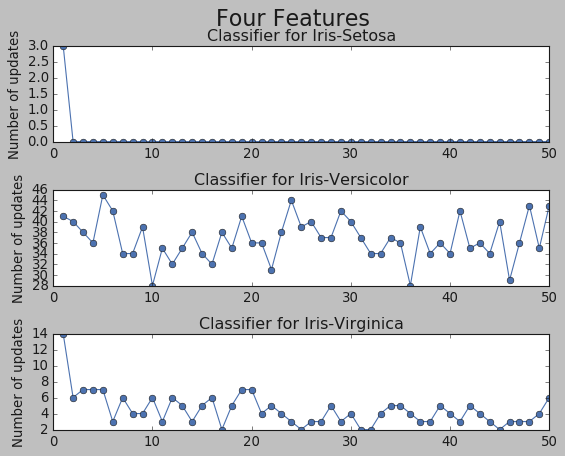

In [220]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3)
plt.style.use('classic')

fig.suptitle('Four Features', fontsize=20)
fig.subplots_adjust(hspace=.5)
ax[0].title.set_text('Classifier for Iris-Setosa')
ax[0].plot(range(1, len(best_ppn['ppn1'].errors_) + 1), best_ppn['ppn1'].errors_, marker='o')
# ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Number of updates')
ax[1].title.set_text('Classifier for Iris-Versicolor')
ax[1].plot(range(1, len(best_ppn['ppn2'].errors_) + 1), best_ppn['ppn2'].errors_, marker='o')
# ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Number of updates')

ax[2].title.set_text('Classifier for Iris-Virginica')
ax[2].plot(range(1, len(best_ppn['ppn3'].errors_) + 1), best_ppn['ppn3'].errors_, marker='o')
# ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Number of updates')
plt.show()

然而我們繪製出來的結果，只有辨別第一類的Model有收斂，顯示可能再切割第二跟第三類的邊界無法完美切割。

### Conclude the accuracy of our model
由於我們沒有使用Validation set，我們直接將我們的Test set丟回Model計算正確率。

In [221]:
predict = []
for xi, target in zip(X_test, y_test):
    predict.append(np.argmax([best_ppn['ppn1'].net_input(xi), best_ppn['ppn2'].net_input(xi), best_ppn['ppn3'].net_input(xi)]))
predict = np.choose(predict, label)
print('Testing Accuracy: %f' % (np.mean(y_test == predict), ))

Testing Accuracy: 0.933333


結論：在我們沒有使用Validation set的情況下，我們得到的Model最終準確率可能會因為我們挑的Test set資料剛好符合某個Learning Rate而出現了Overfitting的情況，但礙於資料數量有限的情況，我們先不要考慮Validation set的情況。以Accuracy來看，我們Train出來的Model應該算不錯。

## Now try to pick only two feature and try the accuracy
In order to acheive better visualization, we want to find the most dominant two features that affects the final result
Since We discover that only the classifier for Setosa will converge, we want to test out what are the two features that will achieve the best testing accuracy

使用Seaborn來看各個Feature之間的狀況

&lt;seaborn.axisgrid.PairGrid at 0x7fe7b8dd7b80&gt;

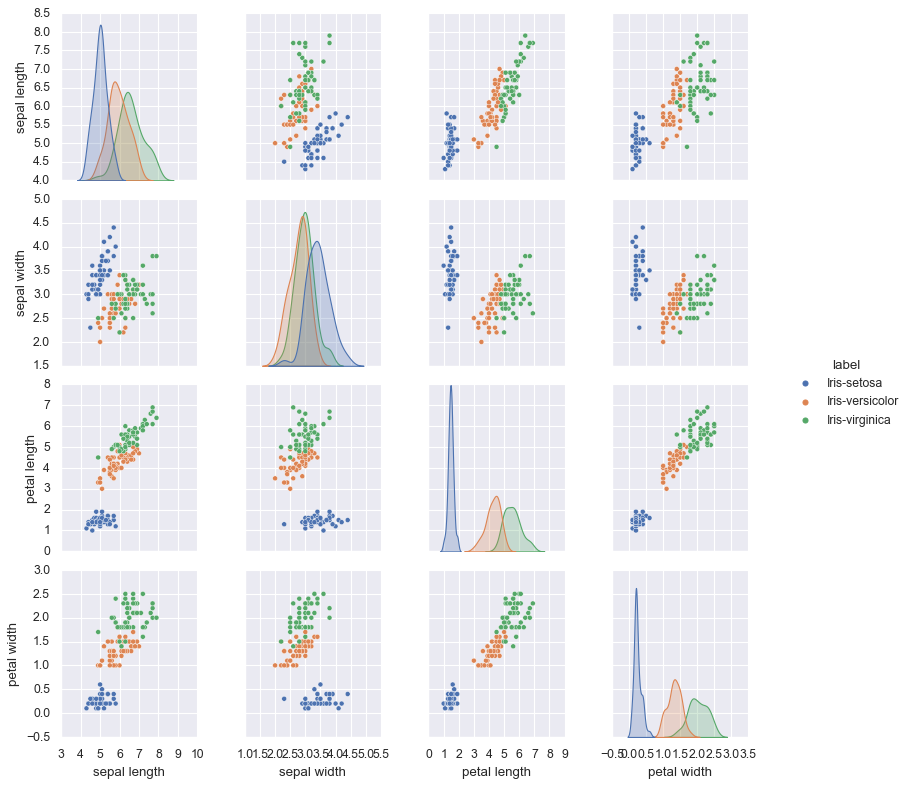

In [222]:
import seaborn as sns
sns.set()
sns.pairplot(df[['sepal length', 'sepal width', 'petal length', 'petal width', 'label']],
             hue="label", diag_kind="kde")


從上圖中我們可以發現，"Petal Length" - "Petal Width"應該是最難用線性模型切割的，因為點跟點之間都重疊了。然後，"Petal Length" - "Petal Width"看起來是最好切的，因此我們使用這兩個Feature來做測試。一樣使用隨機來尋找最好的Learning rate來達到最高的準確率。

In [223]:
X1_train = X_train[:, [2, 3]]
X1_test = X_test[:, [2, 3]]
# first one is the setosa
y1_train = np.where(y_train == 'Iris-setosa', 1, -1)
# second one is the versicolor
y2_train = np.where(y_train == 'Iris-versicolor', 1, -1)
# third one is the virginica
y3_train = np.where(y_train == 'Iris-virginica', 1, -1) 
# Searching for the best learning rate
learning_rates = [0.1, 0.01, 0.12, 0.05, 0.03, 0.11, 0.15, 0.111, 0.2, 0.21, 0.22, 0.23]
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_ppn = {'ppn1': None, 'ppn2': None, 'ppn3': None} # The LinearSVM object that achieved the highest validation rate.
# Three individual models for classifing different classes

for lr in learning_rates:
    ppn1 = Perceptron(eta=lr, n_iter=20)
    ppn1.fit(X1_train, y1_train)
    ppn2 = Perceptron(eta=lr, n_iter=100)
    ppn2.fit(X1_train, y2_train)
    ppn3 = Perceptron(eta=lr, n_iter=30)
    ppn3.fit(X1_train, y3_train)
    predict = []
    for xi, target in zip(X1_test, y_test):
        predict.append(np.argmax([ppn1.net_input(xi), ppn2.net_input(xi), ppn3.net_input(xi)]))
    predict = np.choose(predict, label)
    val_accuracy = np.mean(y_test == predict)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_ppn['ppn1'] = ppn1
        best_ppn['ppn2'] = ppn2
        best_ppn['ppn3'] = ppn3
    results[(lr)] = val_accuracy
for lr in sorted(results):
    val_accuracy = results[(lr)]
    print('lr %e val accuracy: %f' % (lr, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-02 val accuracy: 0.777778
lr 3.000000e-02 val accuracy: 0.911111
lr 5.000000e-02 val accuracy: 0.844444
lr 1.000000e-01 val accuracy: 0.755556
lr 1.100000e-01 val accuracy: 0.844444
lr 1.110000e-01 val accuracy: 0.866667
lr 1.200000e-01 val accuracy: 0.911111
lr 1.500000e-01 val accuracy: 0.933333
lr 2.000000e-01 val accuracy: 0.866667
lr 2.100000e-01 val accuracy: 0.622222
lr 2.200000e-01 val accuracy: 0.844444
lr 2.300000e-01 val accuracy: 0.844444
best validation accuracy achieved during cross-validation: 0.933333


### Plot the "number of updates" curve
檢視如果只有挑選兩個Feature所訓練出來的是否收斂。

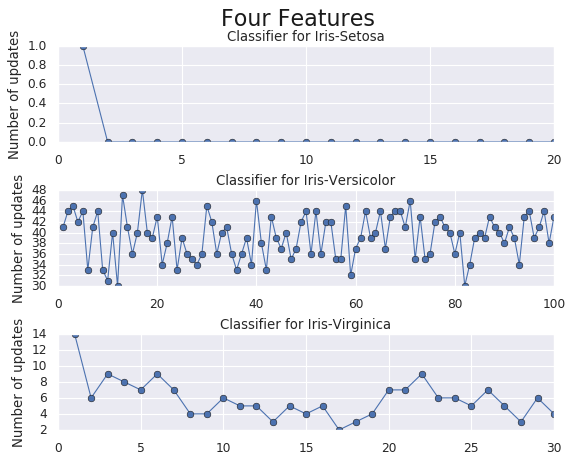

In [224]:
fig, ax = plt.subplots(3)
plt.style.use('classic')
fig.suptitle('Four Features', fontsize=20)
fig.subplots_adjust(hspace=.5)
ax[0].title.set_text('Classifier for Iris-Setosa')
ax[0].plot(range(1, len(best_ppn['ppn1'].errors_) + 1), best_ppn['ppn1'].errors_, marker='o')
# ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Number of updates')
ax[1].title.set_text('Classifier for Iris-Versicolor')
ax[1].plot(range(1, len(best_ppn['ppn2'].errors_) + 1), best_ppn['ppn2'].errors_, marker='o')
# ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Number of updates')

ax[2].title.set_text('Classifier for Iris-Virginica')
ax[2].plot(range(1, len(best_ppn['ppn3'].errors_) + 1), best_ppn['ppn3'].errors_, marker='o')
# ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Number of updates')
plt.show()


我們一樣發現Model 仍然不會收斂

Sepal Length and Sepal Width
Testing accuracy: 0.933333


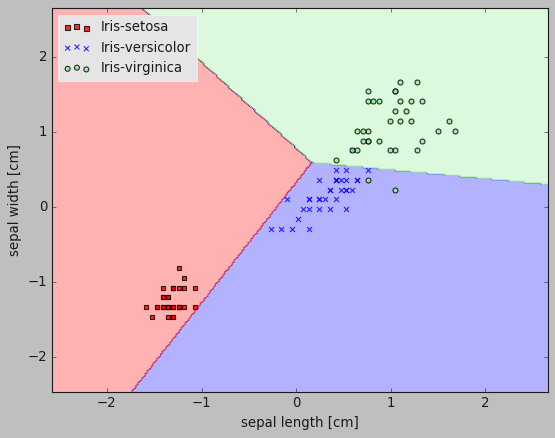

In [225]:
predict = []
for xi, target in zip(X1_test, y_test):
    predict.append(np.argmax([best_ppn['ppn1'].net_input(xi), best_ppn['ppn2'].net_input(xi), best_ppn['ppn3'].net_input(xi)]))
predict = np.choose(predict, label)
print('Sepal Length and Sepal Width')
print('Testing accuracy: %f' % (np.mean(y_test == predict), ))

plot_decision_regions(X1_train, y_train, class1=best_ppn['ppn1'], class2=best_ppn['ppn2'], class3=best_ppn['ppn3'])
plt.style.use('ggplot')

plt.xlabel('sepal length [cm]')
plt.ylabel('sepal width [cm]')
plt.legend(loc='upper left')

# plt.savefig('images/02_08.png', dpi=300)
plt.show()

以上方Train出來的Decision Boundary來說，其實表現是相當不錯的。少許幾個綠點跑進了藍色區域，但由圖中看到他的資料點是有少許糾結的。由上面可以看到，雖然從四個Feature Train出來的準確率比較高，但因為Dataset比較小，我們又沒有使用Validation set的情況下，我們挑選到的Testset可能在選擇四個Feature的情況下比較Match原本的分佈。

在這個Training set比較小的情況下我們只能妥協使用這樣的方法，當Dataset變大時可以使用Validation set去挑選最好的Hyperparameter，這樣可以避免因為Testing data overfit的問題導致準確率飆高。

最後，撇除Overfitting的問題，其實四個Feature跟兩個Feature訓練出來的準確率其實差不多，其實我們可以純粹抽取sepal length跟sepal width來當作我們訓練的Feature，這樣可以加速Training time跟test time。

### 2. Implementing an adaptive linear(AdaLine) neuron in Python
第二題使用Adaline來實做，流程與上一題相同。我們一樣使用課本的code，並在每個Epoch亂數我們Feature矩陣。

In [226]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            # Shuffle the data for a bit
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            net_input = self.net_input(X)
            # Please note that the "activation" method has no effect
            # in the code since it is simply an identity function. We
            # could write `output = self.net_input(X)` directly instead.
            # The purpose of the activation is more conceptual, i.e.,  
            # in the case of logistic regression (as we will see later), 
            # we could change it to
            # a sigmoid function to implement a logistic regression classifier.
            
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

### Training Adaline using four features of the Iris dataset

In [227]:
X_train = X_train
# first one is the setosa
y1_train = np.where(y_train == 'Iris-setosa', 1, -1)
# second one is the versicolor
y2_train = np.where(y_train == 'Iris-versicolor', 1, -1)
# third one is the virginica
y3_train = np.where(y_train == 'Iris-virginica', 1, -1) 

# Store the results
learning_rates = [0.001, 0.0004, 0.0003, 0.0002, 0.0001, 0.00008, 0.00009, 0.00015, 0.00007, 0.00062]
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_ada = {'ada1': None, 'ada2': None, 'ada3': None} # The LinearSVM object that achieved the highest validation rate.
for lr in learning_rates:
# Three individual models for classifing different classes
    ada1 = AdalineGD(n_iter=1000, eta=lr).fit(X_train, y1_train)
    ada2 = AdalineGD(n_iter=1000, eta=lr).fit(X_train, y2_train)
    ada3 = AdalineGD(n_iter=1000, eta=lr).fit(X_train, y3_train)
    # Calculating the accuracy
    predict = []
    for xi, target in zip(X_test, y_test):
        predict.append(np.argmax([ada1.net_input(xi), ada2.net_input(xi), ada3.net_input(xi)]))
    predict = np.choose(predict, label)
    val_accuracy = np.mean(y_test == predict)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_ada['ada1'] = ada1
        best_ada['ada2'] = ada2
        best_ada['ada3'] = ada3
    results[(lr)] = val_accuracy
for lr in sorted(results):
    val_accuracy = results[(lr)]
    print('lr %e val accuracy: %f' % (lr, val_accuracy))
    
print('best validation accuracy achieved during validation: %f' % best_val)

lr 7.000000e-05 val accuracy: 0.866667
lr 8.000000e-05 val accuracy: 0.866667
lr 9.000000e-05 val accuracy: 0.866667
lr 1.000000e-04 val accuracy: 0.866667
lr 1.500000e-04 val accuracy: 0.866667
lr 2.000000e-04 val accuracy: 0.844444
lr 3.000000e-04 val accuracy: 0.822222
lr 4.000000e-04 val accuracy: 0.822222
lr 6.200000e-04 val accuracy: 0.822222
lr 1.000000e-03 val accuracy: 0.800000
best validation accuracy achieved during validation: 0.866667


### PLot the loss function and the accuracy for our best model

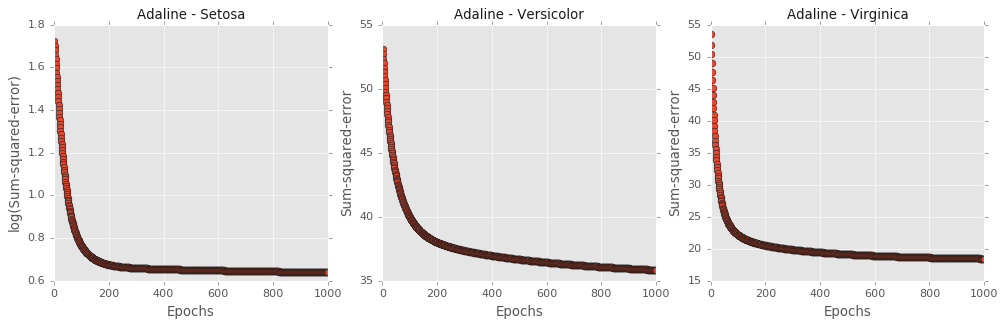

Sepal Length and Sepal Width
Testing accuracy: 0.866667


In [228]:

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
plt.title('Training AdaLine with 4 features')
fig.subplots_adjust(hspace=.5)
ax[0].plot(range(1, len(best_ada['ada1'].cost_) + 1), np.log10(best_ada['ada1'].cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Setosa', fontsize=12)

ax[1].plot(range(1, len(best_ada['ada2'].cost_) + 1), best_ada['ada2'].cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Versicolor', fontsize=12)

ax[2].plot(range(1, len(best_ada['ada3'].cost_) + 1), best_ada['ada3'].cost_, marker='o')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Sum-squared-error')
ax[2].set_title('Adaline - Virginica', fontsize=12)
plt.show()
predict = []
for xi, target in zip(X_test, y_test):
    predict.append(np.argmax([best_ada['ada1'].net_input(xi), best_ada['ada2'].net_input(xi), best_ada['ada3'].net_input(xi)]))
predict = np.choose(predict, label)
print('Sepal Length and Sepal Width')
print('Testing accuracy: %f' % (np.mean(y_test == predict), ))

在Feature全部使用的情況，Perceptron得到了比較高的準確率，這取決於了兩個演算法所Optimize的方向不同，一個使用既定的Update rule，另外一個是針對Loss去Optimize，因此我們切割出來的Decision Boundary自然就不同，進而導致了Accuracy的差距。

### Repeat and choose two of the best features to implement Adaline like we did in Perceptron
Same here, to reduce the complexity and better visualization, we use the two most linearly seperable features to implement Adaline

In [229]:
X1_train = X_train[:, [2, 3]]
X1_test = X_test[:, [2, 3]]
# first one is the setosa
y1_train = np.where(y_train == 'Iris-setosa', 1, -1)
# second one is the versicolor
y2_train = np.where(y_train == 'Iris-versicolor', 1, -1)
# third one is the virginica
y3_train = np.where(y_train == 'Iris-virginica', 1, -1) 

# Store the results
learning_rates = [0.0002, 0.0001, 0.00018, 0.00019, 0.00012, 0.00013, 0.00017, 0.00015, 0.01, 0.02, 0.03]
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_ada = {'ada1': None, 'ada2': None, 'ada3': None} # The LinearSVM object that achieved the highest validation rate.
for lr in learning_rates:
# Three individual models for classifing different classes
    ada1 = AdalineGD(n_iter=2000, eta=lr).fit(X1_train, y1_train)
    ada2 = AdalineGD(n_iter=2000, eta=lr).fit(X1_train, y2_train)
    ada3 = AdalineGD(n_iter=2000, eta=lr).fit(X1_train, y3_train)
    # Calculating the accuracy
    predict = []
    for xi, target in zip(X1_test, y_test):
        predict.append(np.argmax([ada1.net_input(xi), ada2.net_input(xi), ada3.net_input(xi)]))
    predict = np.choose(predict, label)
    val_accuracy = np.mean(y_test == predict)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_ada['ada1'] = ada1
        best_ada['ada2'] = ada2
        best_ada['ada3'] = ada3
    results[(lr)] = val_accuracy
for lr in sorted(results):
    val_accuracy = results[(lr)]
    print('lr %e val accuracy: %f' % (lr, val_accuracy))
    
print('best validation accuracy achieved during validation: %f' % best_val)

lr 1.000000e-04 val accuracy: 0.711111
lr 1.200000e-04 val accuracy: 0.733333
lr 1.300000e-04 val accuracy: 0.711111
lr 1.500000e-04 val accuracy: 0.711111
lr 1.700000e-04 val accuracy: 0.711111
lr 1.800000e-04 val accuracy: 0.711111
lr 1.900000e-04 val accuracy: 0.711111
lr 2.000000e-04 val accuracy: 0.711111
lr 1.000000e-02 val accuracy: 0.000000
lr 2.000000e-02 val accuracy: 0.333333
lr 3.000000e-02 val accuracy: 0.333333
best validation accuracy achieved during validation: 0.733333


### Plot the loss funtion of our two feature Adaline model

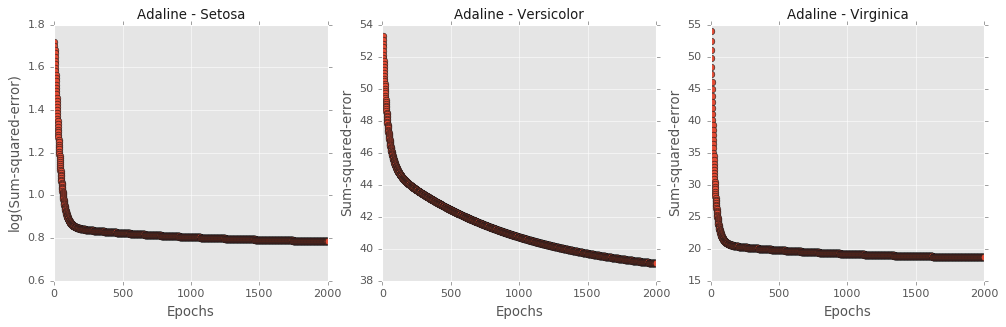

In [230]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
plt.title('Training AdaLine with 4 features')
fig.subplots_adjust(hspace=.5)
ax[0].plot(range(1, len(best_ada['ada1'].cost_) + 1), np.log10(best_ada['ada1'].cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Setosa', fontsize=12)

ax[1].plot(range(1, len(best_ada['ada2'].cost_) + 1), best_ada['ada2'].cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Versicolor', fontsize=12)

ax[2].plot(range(1, len(best_ada['ada3'].cost_) + 1), best_ada['ada3'].cost_, marker='o')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Sum-squared-error')
ax[2].set_title('Adaline - Virginica', fontsize=12)
plt.show()

### The final decision boundary for our 2 feature Adaline model

Sepal Length and Sepal Width
Testing accuracy: 0.733333


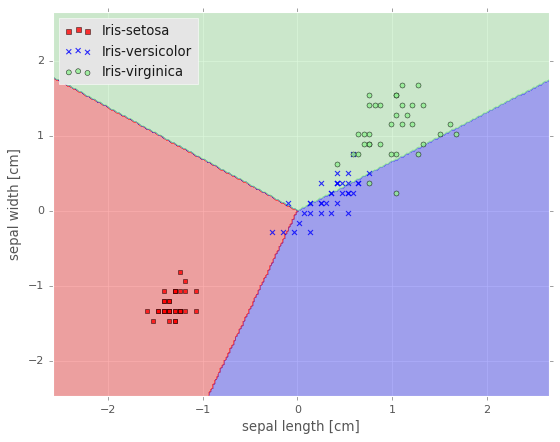

In [231]:
predict = []
for xi, target in zip(X1_test, y_test):
    predict.append(np.argmax([best_ada['ada1'].net_input(xi), best_ada['ada2'].net_input(xi), best_ada['ada3'].net_input(xi)]))
predict = np.choose(predict, label)
print('Sepal Length and Sepal Width')
print('Testing accuracy: %f' % (np.mean(y_test == predict), ))

plot_decision_regions(X1_train, y_train, class1=best_ada['ada1'], class2=best_ada['ada2'], class3=best_ada['ada3'])
plt.style.use('ggplot')

plt.xlabel('sepal length [cm]')
plt.ylabel('sepal width [cm]')
plt.legend(loc='upper left')

# plt.savefig('images/02_08.png', dpi=300)
plt.show()

我們可以看到了，如果我們一樣使用兩個Feature來分別訓練Perceptron跟Adaline，Perceptron仍然表現的比較好。我個人認為Adaline以及Perceptron之間並沒有優劣，準確率可能因為Update rule訓練出來的Boundary不同，在加上可能我們Test set剛好切在錯誤的區域導致的錯誤率偏高。

### 3. Implementing Adaline SGD in Python
第三題使用AdalineSGD來實做，我們一樣使用課本的code，並在每個Epoch亂數我們Feature矩陣。

In [232]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value averaged over all
      training examples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

### First we use all the features and cross-validate to find the greatest model

In [233]:
X_train = X_train
# first one is the setosa
y1_train = np.where(y_train == 'Iris-setosa', 1, -1)
# second one is the versicolor
y2_train = np.where(y_train == 'Iris-versicolor', 1, -1)
# third one is the virginica
y3_train = np.where(y_train == 'Iris-virginica', 1, -1) 

# Store the results
learning_rates = [0.001, 0.0004, 0.0003, 0.0002, 0.0001, 0.00008, 0.00009, 0.00015, 0.01, 0.02, 0.03]
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_ada_sgd = {'ada_sgd1': None, 'ada_sgd2': None, 'ada_sgd3': None} # The LinearSVM object that achieved the highest validation rate.
for lr in learning_rates:
# Three individual models for classifing different classes
    ada_sgd1 = AdalineSGD(n_iter=1000, eta=lr, random_state=1).fit(X_train, y1_train)
    ada_sgd2 = AdalineSGD(n_iter=1000, eta=lr, random_state=1).fit(X_train, y2_train)
    ada_sgd3 = AdalineSGD(n_iter=1000, eta=lr, random_state=1).fit(X_train, y3_train)
    # Calculating the accuracy
    predict = []
    for xi, target in zip(X_test, y_test):
        predict.append(np.argmax([ada_sgd1.net_input(xi), ada_sgd2.net_input(xi), ada_sgd3.net_input(xi)]))
    predict = np.choose(predict, label)
    val_accuracy = np.mean(y_test == predict)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_ada_sgd['ada_sgd1'] = ada_sgd1
        best_ada_sgd['ada_sgd2'] = ada_sgd2
        best_ada_sgd['ada_sgd3'] = ada_sgd3
    results[(lr)] = val_accuracy
for lr in sorted(results):
    val_accuracy = results[(lr)]
    print('lr %e val accuracy: %f' % (lr, val_accuracy))
    
print('best validation accuracy achieved during validation: %f' % best_val)

lr 8.000000e-05 val accuracy: 0.866667
lr 9.000000e-05 val accuracy: 0.866667
lr 1.000000e-04 val accuracy: 0.866667
lr 1.500000e-04 val accuracy: 0.866667
lr 2.000000e-04 val accuracy: 0.844444
lr 3.000000e-04 val accuracy: 0.822222
lr 4.000000e-04 val accuracy: 0.822222
lr 1.000000e-03 val accuracy: 0.800000
lr 1.000000e-02 val accuracy: 0.800000
lr 2.000000e-02 val accuracy: 0.800000
lr 3.000000e-02 val accuracy: 0.822222
best validation accuracy achieved during validation: 0.866667


### Plot the loss curve for our best model

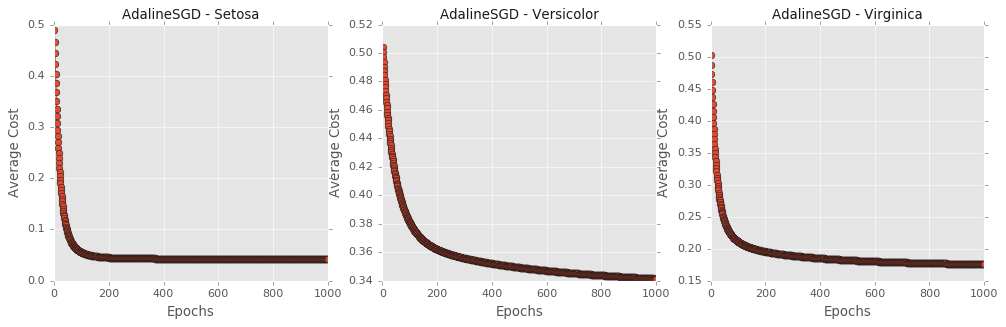

In [234]:
predict = []
for xi, target in zip(X_test, y_test):
    predict.append(np.argmax([best_ada_sgd['ada_sgd1'].net_input(xi), best_ada_sgd['ada_sgd2'].net_input(xi), best_ada_sgd['ada_sgd3'].net_input(xi)]))
predict = np.choose(predict, label)
print('Sepal Length and Sepal Width')
print('Testing accuracy: %f' % (np.mean(y_test == predict), ))
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
plt.title('Training AdaLineSGD with 4 features')
fig.subplots_adjust(hspace=.5)
ax[0].plot(range(1, len(best_ada_sgd['ada_sgd1'].cost_) + 1), (best_ada_sgd['ada_sgd1'].cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Average Cost')
ax[0].set_title('AdalineSGD - Setosa', fontsize=12)

ax[1].plot(range(1, len(best_ada_sgd['ada_sgd2'].cost_) + 1), best_ada_sgd['ada_sgd2'].cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Average Cost')
ax[1].set_title('AdalineSGD - Versicolor', fontsize=12)

ax[2].plot(range(1, len(best_ada_sgd['ada_sgd3'].cost_) + 1), best_ada_sgd['ada_sgd3'].cost_, marker='o')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Average Cost')
ax[2].set_title('AdalineSGD - Virginica', fontsize=12)
plt.show()

### Repeat and choose two of the best features to implement AdalineSGD like we did in Perceptron and Adaline
Same here, to reduce the complexity and better visualization, we use the two most linearly seperable features to implement Adaline

In [235]:
X1_train = X_train[:, [2, 3]]
X1_test = X_test[:, [2, 3]]
X_train = X_train
# first one is the setosa
y1_train = np.where(y_train == 'Iris-setosa', 1, -1)
# second one is the versicolor
y2_train = np.where(y_train == 'Iris-versicolor', 1, -1)
# third one is the virginica
y3_train = np.where(y_train == 'Iris-virginica', 1, -1) 

# Store the results
learning_rates = [0.001, 0.0004, 0.0003, 0.0002, 0.0001, 0.00008, 0.00009, 0.00015]
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_ada_sgd = {'ada_sgd1': None, 'ada_sgd2': None, 'ada_sgd3': None} # The LinearSVM object that achieved the highest validation rate.
for lr in learning_rates:
# Three individual models for classifing different classes
    ada_sgd1 = AdalineSGD(n_iter=1000, eta=lr, random_state=1).fit(X1_train, y1_train)
    ada_sgd2 = AdalineSGD(n_iter=1000, eta=lr, random_state=1).fit(X1_train, y2_train)
    ada_sgd3 = AdalineSGD(n_iter=1000, eta=lr, random_state=1).fit(X1_train, y3_train)
    # Calculating the accuracy
    predict = []
    for xi, target in zip(X1_test, y_test):
        predict.append(np.argmax([ada_sgd1.net_input(xi), ada_sgd2.net_input(xi), ada_sgd3.net_input(xi)]))
    predict = np.choose(predict, label)
    val_accuracy = np.mean(y_test == predict)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_ada_sgd['ada_sgd1'] = ada_sgd1
        best_ada_sgd['ada_sgd2'] = ada_sgd2
        best_ada_sgd['ada_sgd3'] = ada_sgd3
    results[(lr)] = val_accuracy
for lr in sorted(results):
    val_accuracy = results[(lr)]
    print('lr %e val accuracy: %f' % (lr, val_accuracy))
    
print('best validation accuracy achieved during validation: %f' % best_val)

lr 8.000000e-05 val accuracy: 0.711111
lr 9.000000e-05 val accuracy: 0.711111
lr 1.000000e-04 val accuracy: 0.733333
lr 1.500000e-04 val accuracy: 0.733333
lr 2.000000e-04 val accuracy: 0.711111
lr 3.000000e-04 val accuracy: 0.711111
lr 4.000000e-04 val accuracy: 0.711111
lr 1.000000e-03 val accuracy: 0.688889
best validation accuracy achieved during validation: 0.733333


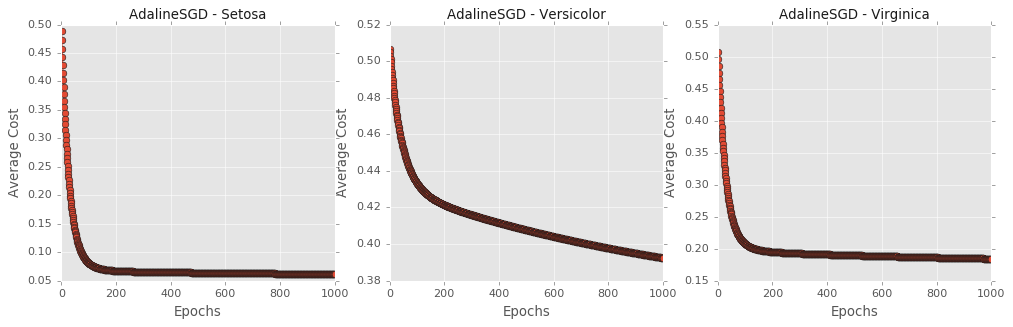

In [236]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
plt.title('Training AdaLineSGD with 4 features')
fig.subplots_adjust(hspace=.5)
ax[0].plot(range(1, len(best_ada_sgd['ada_sgd1'].cost_) + 1), (best_ada_sgd['ada_sgd1'].cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Average Cost')
ax[0].set_title('AdalineSGD - Setosa', fontsize=12)

ax[1].plot(range(1, len(best_ada_sgd['ada_sgd2'].cost_) + 1), best_ada_sgd['ada_sgd2'].cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Average Cost')
ax[1].set_title('AdalineSGD - Versicolor', fontsize=12)

ax[2].plot(range(1, len(best_ada_sgd['ada_sgd3'].cost_) + 1), best_ada_sgd['ada_sgd3'].cost_, marker='o')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Average Cost')
ax[2].set_title('AdalineSGD - Virginica', fontsize=12)
plt.show()

### The final decision boundary for our 2 feature Adaline model

Sepal Length and Sepal Width
Testing accuracy: 0.733333


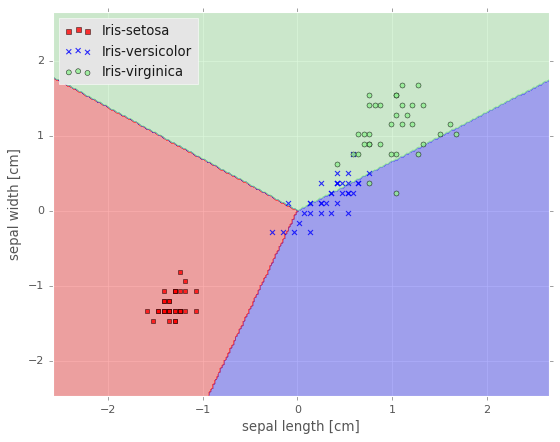

In [237]:
predict = []
for xi, target in zip(X1_test, y_test):
    predict.append(np.argmax([best_ada['ada1'].net_input(xi), best_ada['ada2'].net_input(xi), best_ada['ada3'].net_input(xi)]))
predict = np.choose(predict, label)
print('Sepal Length and Sepal Width')
print('Testing accuracy: %f' % (np.mean(y_test == predict), ))

plot_decision_regions(X1_train, y_train, class1=best_ada['ada1'], class2=best_ada['ada2'], class3=best_ada['ada3'])
plt.style.use('ggplot')

plt.xlabel('sepal length [cm]')
plt.ylabel('sepal width [cm]')
plt.legend(loc='upper left')

# plt.savefig('images/02_08.png', dpi=300)
plt.show()

由以上結果來看，Adaline以及AdalineSGD表現是差不多的，也驗證了兩者應該趨於差不多的理論。

## <u>Question 2</u>
2.For the wine dataset (https://archive.ics.uci.edu/ml/datasets/Wine), please train a
model with the algorithms you have learned now to classify three kinds of wine.


### Implementation
1. 首先我們利用pandas來讀取資料，並將資料做處理，設定各個column的名稱。
2. 在這裡我們使用上題提到的三種Algorithm來試試看整體準確率，然後因為是Multi-class，我們使用Ovr的方法
3. 這裡因為資料量比較大，共178個，我們嘗試看看將整個Training set分成Test set(共28個)來當作最後評估模型準確率的，然後剩下的依據7:3的比例分為Training set以及Validation set避免Overfitting的問題。
4. 使用Test set來評估我們模型的準確率
5. 因為Feature比較多，是個比較複雜的模型，我們直接用所有的Feature來訓練。

### Reading the wine dataset

In [238]:
s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
print('URL:', s)
df_wine = pd.read_csv(s, header=None, encoding='utf-8')
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash','Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

df_wine.tail()
# df_wine[df_wine['Class label'] == 1]

URL: https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data


Class label  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
173            3    13.71        5.65  2.45               20.5         95   
174            3    13.40        3.91  2.48               23.0        102   
175            3    13.27        4.28  2.26               20.0        120   
176            3    13.17        2.59  2.37               20.0        120   
177            3    14.13        4.10  2.74               24.5         96   

     Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
173           1.68        0.61                  0.52             1.06   
174           1.80        0.75                  0.43             1.41   
175           1.59        0.69                  0.43             1.35   
176           1.65        0.68                  0.53             1.46   
177           2.05        0.76                  0.56             1.35   

     Color intensity   Hue  OD280/OD315 of diluted wines  Proline  
173              7.7  0.64                          1.74      740  
174              7.3  0.70                          1.56      750  
175             10.2  0.59                          1.56      835  
176              9.3  0.60                          1.62      840  
177              9.2  0.61                          1.60      560

### Extract the data
在這裡我們將資料分成Train, validation, test

In [239]:
# since we are required to use the one-vs-all with 3 classes
# we need to generate 3 perceptron models
# first extract the labels
y = df_wine['Class label'].values
# extract the features and standardize
X = df_wine.drop(columns = ['Class label']).values
# Now split the data into 7:3 (total of 178 data)
idx = np.arange(X.shape[0])
train = idx[idx % 19 < 11]
X_train = np.array(X[train])
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
y_train = np.array(y[train])
val = idx[(idx % 19 >= 11) & (idx % 19 < 16)]
X_val = np.array(X[val])
X_val = (X_val - np.mean(X_val, axis=0)) / np.std(X_val, axis=0)
y_val = np.array(y[val])
test = idx[idx % 19 >= 16]
X_test = np.array(X[test])
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)
y_test = np.array(y[test])
print("Training set size = ", y_train.shape[0])
print("Validation set size = ", y_val.shape[0])
print("Testing set size = ", y_test.shape[0])

Training set size =  106
Validation set size =  45
Testing set size =  27


### Using the perceptron model to train and cross-validation
使用Train set來訓練然後用Validation set來Cross validate

In [240]:
y1_train = np.where(y_train == 1, 1, -1)
y2_train = np.where(y_train == 2, 1, -1)
y3_train = np.where(y_train == 3, 1, -1)
# Store the results
learning_rates = [0.1, 0.01, 0.12, 0.05, 0.03, 0.11, 0.15, 0.111, 0.2]
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_ppn = {'ppn1': None, 'ppn2': None, 'ppn3': None} # The LinearSVM object that achieved the highest validation rate.
for lr in learning_rates:
    ppn1 = Perceptron(eta=lr, n_iter=50)
    ppn1.fit(X_train, y1_train)
    ppn2 = Perceptron(eta=lr, n_iter=50)
    ppn2.fit(X_train, y2_train)
    ppn3 = Perceptron(eta=lr, n_iter=50)
    ppn3.fit(X_train, y3_train)
    # Calculating the accuracy
    predict = []
    for xi, target in zip(X_val, y_val):
        predict.append(np.argmax([ppn1.net_input(xi), ppn2.net_input(xi), ppn3.net_input(xi)]) + 1)
    val_accuracy = np.mean(y_val == predict)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_ppn['ppn1'] = ppn1
        best_ppn['ppn2'] = ppn2
        best_ppn['ppn3'] = ppn3
    results[(lr)] = val_accuracy
for lr in sorted(results):
    val_accuracy = results[(lr)]
    print('lr %e val accuracy: %f' % (lr, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-02 val accuracy: 0.977778
lr 3.000000e-02 val accuracy: 0.977778
lr 5.000000e-02 val accuracy: 1.000000
lr 1.000000e-01 val accuracy: 1.000000
lr 1.100000e-01 val accuracy: 1.000000
lr 1.110000e-01 val accuracy: 1.000000
lr 1.200000e-01 val accuracy: 1.000000
lr 1.500000e-01 val accuracy: 0.977778
lr 2.000000e-01 val accuracy: 0.977778
best validation accuracy achieved during cross-validation: 1.000000


### Plot the number of update for our best model
檢視模型是否收斂

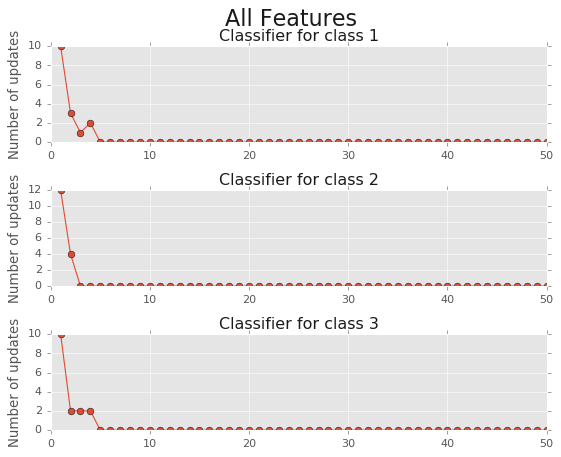

In [241]:
fig, ax = plt.subplots(3)
plt.style.use('classic')

fig.suptitle('All Features', fontsize=20)
fig.subplots_adjust(hspace=.5)
ax[0].title.set_text('Classifier for class 1')
ax[0].plot(range(1, len(best_ppn['ppn1'].errors_) + 1), best_ppn['ppn1'].errors_, marker='o')
# ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Number of updates')
ax[1].title.set_text('Classifier for class 2')
ax[1].plot(range(1, len(best_ppn['ppn2'].errors_) + 1), best_ppn['ppn2'].errors_, marker='o')
# ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Number of updates')

ax[2].title.set_text('Classifier for class 3')
ax[2].plot(range(1, len(best_ppn['ppn3'].errors_) + 1), best_ppn['ppn3'].errors_, marker='o')
# ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Number of updates')
plt.show()

這次的Perceptron有正常收斂！

### Use the test set to verify our accuracy

In [242]:
predict = []
for xi, target in zip(X_test, y_test):
    predict.append(np.argmax([best_ppn['ppn1'].net_input(xi), best_ppn['ppn2'].net_input(xi), best_ppn['ppn3'].net_input(xi)]) + 1)
print('Testing Accuracy: %f' % (np.mean(y_test == predict), ))

Testing Accuracy: 0.962963


### Now trying Adaline using the same sets
重複上面，我們改用Adaline試試看

### Extract data

In [243]:
print("Training set size = ", y_train.shape[0])
print("Validation set size = ", y_val.shape[0])
print("Testing set size = ", y_test.shape[0])

Training set size =  106
Validation set size =  45
Testing set size =  27


### Train and Cross-Validate

In [244]:
y1_train = np.where(y_train == 1, 1, -1)
y2_train = np.where(y_train == 2, 1, -1)
y3_train = np.where(y_train == 3, 1, -1)

# Store the results
learning_rates = [0.001, 0.0004, 0.0003, 0.0002, 0.0001, 0.00008, 0.00009, 0.00015]
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_ada = {'ada1': None, 'ada2': None, 'ada3': None} # The LinearSVM object that achieved the highest validation rate.
for lr in learning_rates:
# Three individual models for classifing different classes
    ada1 = AdalineGD(n_iter=500, eta=lr).fit(X_train, y1_train)
    ada2 = AdalineGD(n_iter=500, eta=lr).fit(X_train, y2_train)
    ada3 = AdalineGD(n_iter=500, eta=lr).fit(X_train, y3_train)
    # Calculating the accuracy
    predict = []
    for xi, target in zip(X_val, y_val):
        predict.append(np.argmax([ada1.net_input(xi), ada2.net_input(xi), ada3.net_input(xi)]) + 1)
    val_accuracy = np.mean(y_val == predict)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_ada['ada1'] = ada1
        best_ada['ada2'] = ada2
        best_ada['ada3'] = ada3
    results[(lr)] = val_accuracy
for lr in sorted(results):
    val_accuracy = results[(lr)]
    print('lr %e val accuracy: %f' % (lr, val_accuracy))
    
print('best validation accuracy achieved during validation: %f' % best_val)

lr 8.000000e-05 val accuracy: 0.977778
lr 9.000000e-05 val accuracy: 0.977778
lr 1.000000e-04 val accuracy: 0.977778
lr 1.500000e-04 val accuracy: 0.977778
lr 2.000000e-04 val accuracy: 0.977778
lr 3.000000e-04 val accuracy: 0.977778
lr 4.000000e-04 val accuracy: 1.000000
lr 1.000000e-03 val accuracy: 1.000000
best validation accuracy achieved during validation: 1.000000


### Plot the loss curve of the best model determined using cross-validation

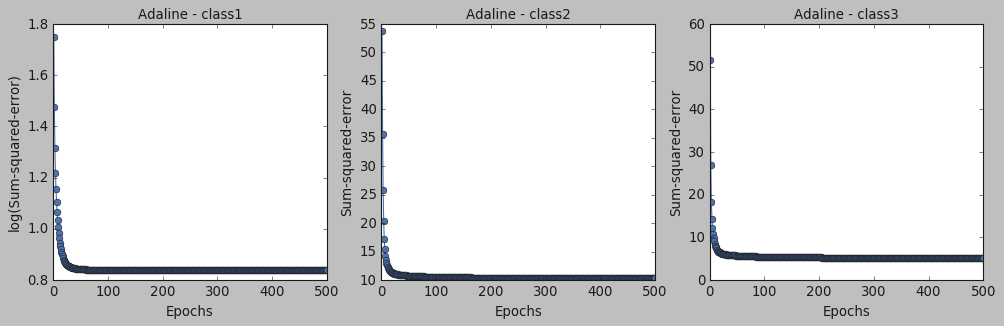

In [245]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
plt.title('Training AdaLine with all the features')
fig.subplots_adjust(hspace=.5)
ax[0].plot(range(1, len(best_ada['ada1'].cost_) + 1), np.log10(best_ada['ada1'].cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - class1', fontsize=12)

ax[1].plot(range(1, len(best_ada['ada2'].cost_) + 1), best_ada['ada2'].cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - class2', fontsize=12)

ax[2].plot(range(1, len(best_ada['ada3'].cost_) + 1), best_ada['ada3'].cost_, marker='o')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Sum-squared-error')
ax[2].set_title('Adaline - class3', fontsize=12)
plt.show()

### Use the test set to verify our accuracy

In [246]:
predict = []
for xi, target in zip(X_test, y_test):
    predict.append(np.argmax([best_ada['ada1'].net_input(xi), best_ada['ada2'].net_input(xi), best_ada['ada3'].net_input(xi)]) + 1)
print('Testing Accuracy: %f' % (np.mean(y_test == predict), ))

Testing Accuracy: 0.962963


在這個Case之下與Perceptron有差不多的表現，應該是資料點比較Linearly Seperable的原因，讓兩種演算法都能夠成功完美切割。

### Now trying AdalineSGD using the same sets

In [247]:
print("Training set size = ", y_train.shape[0])
print("Validation set size = ", y_val.shape[0])
print("Testing set size = ", y_test.shape[0])

Training set size =  106
Validation set size =  45
Testing set size =  27


In [248]:
y1_train = np.where(y_train == 1, 1, -1)
y2_train = np.where(y_train == 2, 1, -1)
y3_train = np.where(y_train == 3, 1, -1)

# Store the results
learning_rates = [0.001, 0.0004, 0.0003, 0.0002, 0.0001, 0.00008, 0.00009, 0.00015]
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_ada_sgd = {'ada_sgd1': None, 'ada_sgd2': None, 'ada_sgd3': None} # The LinearSVM object that achieved the highest validation rate.
for lr in learning_rates:
# Three individual models for classifing different classes
    ada_sgd1 = AdalineSGD(n_iter=500, eta=lr).fit(X_train, y1_train)
    ada_sgd2 = AdalineSGD(n_iter=500, eta=lr).fit(X_train, y2_train)
    ada_sgd3 = AdalineSGD(n_iter=500, eta=lr).fit(X_train, y3_train)
    # Calculating the accuracy
    predict = []
    for xi, target in zip(X_val, y_val):
        predict.append(np.argmax([ada_sgd1.net_input(xi), ada_sgd2.net_input(xi), ada_sgd3.net_input(xi)]) + 1)
    val_accuracy = np.mean(y_val == predict)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_ada_sgd['ada_sgd1'] = ada_sgd1
        best_ada_sgd['ada_sgd2'] = ada_sgd2
        best_ada_sgd['ada_sgd3'] = ada_sgd3
    results[(lr)] = val_accuracy
for lr in sorted(results):
    val_accuracy = results[(lr)]
    print('lr %e val accuracy: %f' % (lr, val_accuracy))
    
print('best validation accuracy achieved during validation: %f' % best_val)

lr 8.000000e-05 val accuracy: 0.977778
lr 9.000000e-05 val accuracy: 0.977778
lr 1.000000e-04 val accuracy: 0.977778
lr 1.500000e-04 val accuracy: 0.977778
lr 2.000000e-04 val accuracy: 0.977778
lr 3.000000e-04 val accuracy: 0.977778
lr 4.000000e-04 val accuracy: 1.000000
lr 1.000000e-03 val accuracy: 1.000000
best validation accuracy achieved during validation: 1.000000


### Plot the loss curve of the best model determined using cross-validation

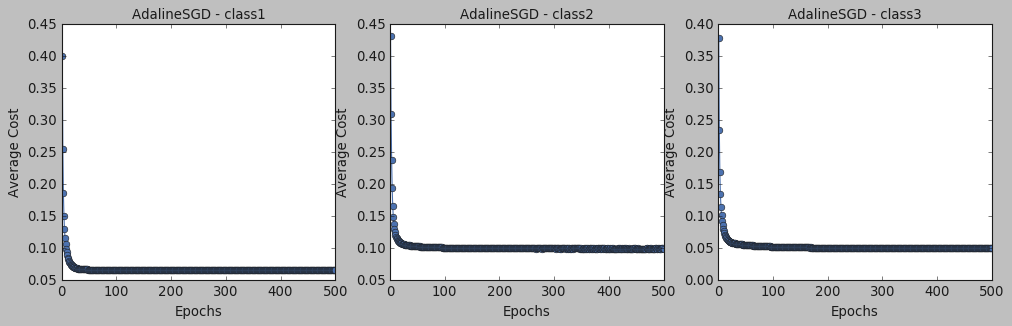

In [249]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
plt.title('Training AdaLine with all the features')
fig.subplots_adjust(hspace=.5)
ax[0].plot(range(1, len(best_ada_sgd['ada_sgd1'].cost_) + 1), (best_ada_sgd['ada_sgd1'].cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Average Cost')
ax[0].set_title('AdalineSGD - class1', fontsize=12)

ax[1].plot(range(1, len(best_ada_sgd['ada_sgd2'].cost_) + 1), best_ada_sgd['ada_sgd2'].cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Average Cost')
ax[1].set_title('AdalineSGD - class2', fontsize=12)

ax[2].plot(range(1, len(best_ada_sgd['ada_sgd3'].cost_) + 1), best_ada_sgd['ada_sgd3'].cost_, marker='o')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Average Cost')
ax[2].set_title('AdalineSGD - class3', fontsize=12)
plt.show()

### Use the test set to verify our accuracy

In [250]:
predict = []
for xi, target in zip(X_test, y_test):
    predict.append(np.argmax([best_ada_sgd['ada_sgd1'].net_input(xi), best_ada_sgd['ada_sgd2'].net_input(xi), best_ada_sgd['ada_sgd3'].net_input(xi)]) + 1)
print('Testing Accuracy: %f' % (np.mean(y_test == predict), ))

Testing Accuracy: 0.962963


預期之下，AdalineSGD跟Adaline應該要有差不多的準確率，而這裡驗證了我們的預期。

Question 2 Summary: 比起在Iris的case中我們無法直接視覺化，但在Wine的例子中三種不同模型得到的準確率都高於Iris dataset，原因應該就是因為Data比較好分割，雖然我們無法視覺化。因此在Wine的案例中，三種演算法的好壞應該是差不多的。

### Discussion
我的專題是直接從Deep Learning開始做，其實有很多ML的基礎感覺不是很扎實。這次的作業透過手刻最簡單的Linear Classfier來讓我真正看見Classifier內部的運作方式，還有關於資料的處理等等我是第一次手刻，雖然比起直接Call Funtion困難許多，但我覺得透過這樣的方式可以真正檢視自己有沒有學會。像是標準化，我們應該要很清楚自己的Test data不能跟Training data一起丟進去標準化，剛開始的我直接混在一起了，還有關於Cross validation，Gradinet update等等，經過手刻之後更讓我清楚了內部的運作方式，流程都要很清楚了。把它思考成Computation graph才能寫出Code.

另外我原本以為越複雜的Model表現會越好，比如以這個作業來說，Adaline跟Perceptron，我原本以為Adaline的表現會比較好，結果反而是另外一個，這也說明了ML領域沒有一個直接的數學公式可以直接說哪種Model比較好，只能透過各種不同嘗試去尋找最好的解法。

另外再做Wine Dataset的時候，因為Feature比較多很難視覺化，讓我很期待後面的課程，究竟如何降低一筆高維度的資料到低維度，我很好奇他轉換的過程。希望可以學到這個方法，因為在Training的過程中明顯感覺到它比Iris dataset Training還要久，雖然我們最終得到了很好的準確率，但設計一個好的模型除了準確率，效能也是我們要考慮的。如果手邊運算資源不足的話可能會讓使用者端的使用體驗變差。